<a href="https://colab.research.google.com/github/baigouy/notebooks/blob/master/Epyseg_build_and_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before you start

__Note: You are using this at your own risk__, the author cannot be help responsible for damage to Google drive or misfunction of the e-mail account (due drive overfilling). To avoid issues please use a second account dedicated to deep learning. __If you disagree, please quit this page__.

[General colab notebook tips](https://github.com/baigouy/notebooks#getting-started)

# Step 1:
- Mount Google drive ([How to](https://github.com/baigouy/notebooks#how-to-mount-google-drive-in-colab)).
- Select a GPU runtime ([How to](https://github.com/baigouy/notebooks#select-a-gpu-runtime)).
- Then run the code cell below ([How to](https://github.com/baigouy/notebooks#how-to-run-a-code-cell)).

In [2]:
#@title <-- Press Run

%tensorflow_version 2.x
import tensorflow as tf
import sys
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Markdown, display
import os

# defining an html/md formatting print function
def printmd(string):
    display(Markdown(string))

# defining a filebrowser that can be used later on
# FileBrowser modified from DrDub https://gist.github.com/DrDub/6efba6e522302e43d055 PD licence
# new beahviour: single click selects a file or a folder, double click browses folders. Blocked browsing of files as if they were folders. Has an option to show files or not (files are shown by default).
# Note that I have made a very quick n dirty hack of the initial nice code so that it handles double click, my changes would need some love but it seems functional, please report bugs to BA otherwise
# TODO also maybe hack it to select files only or folders or maybe ignore and do the check later and put a warning accordingly (maybe simpler for now)


import os
import ipywidgets as widgets
from ipywidgets import Layout, Button, VBox, Label,Box, HBox, ButtonStyle
from timeit import default_timer as timer

class FileBrowser(object):
    def __init__(self, width='auto', height="200px", item_width="auto", item_height="auto", folders_only=False):
        
        self.folders_only = folders_only
        self.path = os.getcwd()
        self._update_files()
        
        self.layout = Layout(overflow='scroll',
                             border ='1px solid black',
                             width  ='{}'.format(width),
                             height ='{}'.format(height),
                             flex_flow = "column wrap",
                             align_items = "flex-start",
                             display='flex')
        
        self.button_dir_syle  = ButtonStyle(button_color='lightgray')
        self.button_file_syle = ButtonStyle(button_color='#Fafaff')
        
        self.button_layout    = Layout(left="0px", width="{}".format(item_width), height="{}".format(item_height))
        self.last_click = None
        self.root_folder = None
        
        
    def _update_files(self):
        self.files = list()
        self.dirs  = list()
        # print('is dir', self.path, os.path.isdir(self.path))
        if(os.path.isdir(self.path)):
            for f in os.listdir(self.path):
                ff = os.path.join(self.path,f)
                if os.path.isdir(ff):
                    self.dirs.append(f)
                else:
                    self.files.append(f)
        
    def widget(self):
        list_box = widgets.Box(layout=self.layout)
        box = VBox([list_box, Label(self.path)])
        self._update_box(box)
        
        return box
    
    
    def _update_box(self, main_box, double_click=True):
        # print('double click in there', double_click)
        path_label = main_box.children[1]
        file_or_path = "Selected file: {}"
        if os.path.isdir(self.path):
          file_or_path = "Selected path: {}"
        path_label.value = file_or_path.format(self.path)
        
        if self.root_folder is None:
          self.root_folder = self.path

        box        = main_box.children[0]
        if not double_click:
          # print('skipping')
          return box
        else:
          if (os.path.isfile(self.path)):
            # prevent 'browsing' files
            return box
          # print('starting path', self.path)
          self.root_folder = self.path

        def on_click(b):
            double_click = False

            # detect single or double click and act accordingly (dirty hack by BA)
            if self.last_click is not None:
              # print('delay',timer()-self.last_click)
              if timer()-self.last_click<=0.600:
                # print('double click')
                double_click = True
              else:
                # print('single click')
                self.last_click = timer()
            else:
              self.last_click = timer()  
              # print('single click')          

            if b.description == '..':
                if not double_click: #skip double click for previous folder
                  self.path = os.path.split(self.root_folder)[0]

                double_click=True
                # print('path parent',self.path)
            else:
                if not double_click:
                  self.path = os.path.join(self.root_folder, b.description)
                else:
                  self.path = os.path.join(self.root_folder, b.description)

            self._update_files()
            self._update_box(main_box, double_click)

        buttons = []
        if os.path.dirname(self.path) != self.path:
            button = widgets.Button(description='..', style=ButtonStyle(button_color='lightblue'), layout=self.button_layout)
            button.on_click(on_click)
            buttons.append(button)
        
        for f in self.dirs:
            button = widgets.Button(description=f, style=self.button_dir_syle, icon='fa-folder', tooltip=f, layout=self.button_layout)
            button.on_click(on_click)
            buttons.append(button)
        
        if not self.folders_only:
          for f in self.files:
              button = widgets.Button(description=f, style=self.button_file_syle, tooltip=f, layout=self.button_layout)
              button.on_click(on_click)
              buttons.append(button)
            
        box.children = buttons


try:
  # check that google drive is successfully mounted
  
  if os.path.exists('/content/drive/My Drive'):#/content/dri #create an error # /content/drive/My Drive # full path
    printmd('<font color="green">Google drive successfully mounted!</font>')
    # move to the drive folder
    %cd /content/drive/My Drive
  else:
    from google.colab import drive
    printmd('<font color="green"><b>Open the external link and follow the instructions until you get the authorization code. Copy this code, paste it below then press "Enter"</b></font>')
    drive.mount('/content/drive')

    if not os.path.exists('/content/drive/My Drive'):
      printmd('<font color="red">Please connect to Google drive and repeat this step:</font>')
      print('How to: https://github.com/baigouy/notebooks#how-to-mount-google-drive-in-colab') # could be useful indeed
      #assert False
      raise Exception('error!')
    else:
      printmd('<font color="green">Google drive successfully mounted!</font>')
    # sys.exit()
    #quit(keep_kernel=False)

  # check we are using GPU
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    printmd('<font color="red">GPU not found, please repeat this step.</font>')
    print('How to: https://github.com/baigouy/notebooks#select-a-gpu-runtime') # could be useful indeed
    # should also do that first and print the link to help people use this stuff!!!
    # quit
    raise Exception('error!')
  else:
    printmd('<font color="green">GPU found!</font>')
    # should I merge all in one single step because if anyway anything fails it is not gonna work...
    # maybe it's an idea

  printmd('<br><font color="green">Everything went fine, please move on to next step!</font>')
except:
  pass


# printmd('this is a test')

<font color="green">Google drive successfully mounted!</font>

/content/drive/My Drive


<font color="green">GPU found!</font>

<br><font color="green">Everything went fine, please move on to next step!</font>

# Step 2:
- Install the required python libraries by running the code cell below (please be patient, this may take time...)

In [3]:
#@title <-- Press Run

# slow --> keep it as a separate step
# install python libraries necessary to run epyseg
# TODO check that all those libs are reallyu required but ok for now
!pip install czifile
!pip install h5py
!pip install Markdown
!pip install matplotlib
!pip install numpy
!pip install numpydoc
!pip install Pillow
!pip install PyQt5
!pip install PyQtWebEngine
!pip install read-lif
!pip install scikit-image
!pip install scipy
!pip install segmentation-models==1.0.1
!pip install tifffile
!pip install natsort
!pip install numexpr
!pip install --no-deps epyseg # prevent reinstalling tf 2.x and rather use the google optimized tf
# libraries loaded checking epyseg to see if everything is functional
try:
  from epyseg.img import Img
  # just try import any class from Epyseg --> will raise an error if loading fails if loads most likely everything should work
  from epyseg.deeplearning.deepl import EZDeepLearning
  from epyseg.deeplearning.augmentation.meta import MetaAugmenter
  from epyseg.deeplearning.augmentation.generators.data import DataGenerator
  deepTA = EZDeepLearning()
  printmd('<br><font color="green">EPySeg succesfully loaded, please move on to next step!</font>') 
except:
  printmd('<br><font color="red">EPySeg failed to load. Please repeat this step</font>.')

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 76.6MB 41kB/s 
     |████████████████████████████████| 286kB 35.6MB/s 
     |████████████████████████████████| 65.9MB 87kB/s 
  Created wheel for read-lif: filename=read_lif-0.4.0-cp36-none-any.whl size=23772 sha256=d283bf2dff5935f2a58c46abbae0017a56c1048eda2e9b79b61347da6bc0e7ce
  Stored in directory: /root/.cache/pip/wheels/e6/94/c5/4662763128458e7f214480ac95eef85a5618d852eaa6383299
Successfully built read-lif
     |████████████████████████████████| 153kB 3.5MB/s 
Segmentation Models: using `tf.keras` framework.
Using tensorflow version 2.2.0
Using segmentation models version 1.0.1


<br><font color="green">EPySeg succesfully loaded, please move on to next step!</font>

# Step 3
- Run the cell below and choose between loading or building a model, then move to next cell.

In [4]:
#@title <-- Press Run

label = widgets.Label('Please make a choice:')
# cannot be horizontal https://github.com/jupyter-widgets/ipywidgets/issues/1247
options = [['Build a new model',1], ['Load an existing model',2] ] #,['Use a pre-trained model',3]
model = widgets.RadioButtons(options=options)

ui = widgets.VBox([label, model])
display(ui) 

# Step 4
- Please run the cell below and follow output instructions

In [7]:
#@title <-- Press Run

# print(model.value)
if model.value == 1:
  # print('build')
  # should offer loading a model from drive
  # should I allow to locate a file ????

  label_mod_params = Label('Please select model parameters (then move to next step):')
  # get all available model architectures
  available_architectures = deepTA.available_model_architectures
  architecture = widgets.Dropdown(
      value='Linknet',
      placeholder='Choose an architecture',
      options=available_architectures,
      description='Architecture',
      ensure_option=True,
      disabled=False,
      layout={'width': 'max-content'},
      style={'description_width': 'initial'}
  )

  # get all available backbones
  available_backbones = deepTA.available_sm_backbones
  backbone = widgets.Dropdown(
      value='vgg16',
      placeholder='Choose a backbone',
      options=available_backbones,
      description='Backbone',
      ensure_option=True,
      disabled=False,
      layout={'width': 'max-content'},
      style={'description_width': 'initial'}
  )

  # get all available activation for the last layer
  available_activations = deepTA.last_layer_activation
  activation = widgets.Dropdown(
      value='sigmoid',
      placeholder='Choose an activation',
      options=available_activations,
      description='Activation',
      ensure_option=True,
      disabled=False,
      layout={'width': 'max-content'},
      style={'description_width': 'initial'}
  )

  # model input width
  input_width = widgets.IntSlider(description='Width (0 = None = any size)', value=128, min=0, max=1024, step=2, style={'description_width': 'initial'})
  # model input height
  input_height = widgets.IntSlider(description='Height (0 = None = any size)', value=128, min=0, max=1024, step=2, style={'description_width': 'initial'})
  # model input channels
  inp_channels = widgets.IntSlider(description='Input channels', min=1, step=1, style={'description_width': 'initial'})
  # model output channels
  classes = widgets.IntSlider(description='Classes', min=1, step=1, style={'description_width': 'initial'})
  ui = widgets.VBox([label_mod_params, architecture, backbone, input_width, input_height, inp_channels,activation, classes])
  display(ui) 
elif model.value == 2:
  # print('load')
  # browse for input model
  load_model_label = Label('Please select a model file and move on to next step:')
  model_path = FileBrowser(folders_only=False) #item_width="140px"
  ui = widgets.VBox([load_model_label, model_path.widget()])
  display(ui)


# else: # TODO deactivate for now!!!
  # print('pre-trained')

# Step 5
- Please run the cell below and follow instructions

In [8]:
#@title <-- Press Run

deepTA.model = None # does it really reset model or not
try:
  action = 'built'
  # First we try to build or load the model and if something goes wrong ask to repeat step 4
  if model.value == 1:
    # build model from scratch
    

    # architecture, backbone, input_width, input_height, inp_channels,activation, classes
    deepTA.load_or_build(architecture=architecture.value, backbone=backbone.value, activation=activation.value, classes=classes.value, input_width=input_width.value, input_height=input_height.value, input_channels=inp_channels.value)
    # deepTA.summary()
    # if deepTA.model is None:
      # printmd('<font color="green">Model successfully built!</font>')
    # else:
      # printmd('<font color="red">Could not build model, please check the model parameters. Repeat Step 4</font>')
  elif model.value == 2:
    # try to load an existing model and report error if model could not be loaded
    action = 'loaded'
    # check wether model can be loaded 

    path = model_path.path
    if not os.path.exists(path):
      printmd('<font color="red">Please provide a valid model path. </font>')
      raise Exception('error!')
    else:
      # try load the model and return error upon failure
      # printmd('<font color="red">test!</font>')
      deepTA.load_or_build(model=path)

      
  if deepTA.model is None:
    printmd('<font color="red">Empty model!</font>')
    raise Exception('error!')
  else:
    deepTA.summary()
    printmd('<font color="green">Model succesfully '+ action +', please move on to next step!</font>')

except:
  printmd('<font color="red">Something went wrong, please repeat step 4</font>')
  pass

INFO - 2020-06-23 07:54:48,890 - deepl.py - summary - line 613 - None



Model: "Linknet-vgg16-sigmoid"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, None, None, 1)]          0                                                                   
______________________________________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                            (None, None, None, 64)           640               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
block1_conv2 (Conv2D)                            (None, None, N

<font color="green">Model succesfully built, please move on to next step!</font>

# Step 6
- Run the cell below and decide whether or not to load model weights then move to next step

In [9]:
#@title <-- Press Run

f = FileBrowser(folders_only=False) #item_width="140px"
options2 = [['No',2],['Yes',1] ] #,['Use a pre-trained model',3]    
drop_load_weights = widgets.Dropdown(options=options2, description='Load model weights:', layout={'width': 'max-content'}, style={'description_width': 'initial'})

def browse_for_weights(x):
    if x == 1:
      weight_label = Label('Please select a weight file in your drive, then move on to next step:')
      ui = widgets.VBox([weight_label, f.widget()])
      display(ui)
    else:
      weight_label = Label('No weights to load, then please move on to next step')
      display(weight_label)


interact(browse_for_weights, x=drop_load_weights);



interactive(children=(Dropdown(description='Load model weights:', layout=Layout(width='max-content'), options=…

# Step 8
- Run the cell below and follow the instructions

In [10]:
#@title <-- Press run

if drop_load_weights.value == 1:
  try:
    deepTA.load_weights(f.path)
    printmd('<font color="green">Weights succesfully loaded. Please move on to next step!</font>')
  except:
    printmd('<font color="red">Something went wrong (file corrupt/wrong file), please repeat step 7.</font>')
else:
  printmd('<font color="green">Please move on to next step!</font>')

<font color="green">Please move on to next step!</font>

# Step 9
- Run the cell to verify model compilation or set compilation parameters

In [12]:
#@title <-- Press Run

# check if already compiled and if so ask wether to go on or not or force recompile

# to choose the network optimizer, loss and metric

# get available optimizers
available_optimizers = deepTA.optimizers
optimizers = widgets.Dropdown(
    value='adam',
    placeholder='Choose an optimizer',
    options=available_optimizers,
    description='Optimizer',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

# get available losses
available_losses = deepTA.loss.keys()
losses = widgets.Dropdown(
    value='jaccard_loss',
    placeholder='Choose a loss function',
    options=available_losses,
    description='Loss function',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

# get available metrics
available_metrics = deepTA.metrics.keys()
metrics = widgets.Dropdown(
    value='iou_score',
    placeholder='Choose a metric',
    options=available_metrics,
    description='Metric',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

force_recompile = not deepTA.is_model_compiled()
ui = widgets.VBox([losses, metrics, optimizers])

options2 = [['No',2],['Yes',1]] #,['Use a pre-trained model',3]    
force_recompile_drop = widgets.Dropdown(options=options2, description='Force recompile:', layout={'width': 'max-content'}, style={'description_width': 'initial'})  

def recompile_model(x):
    if x == 1:
      # model is already compiled offer a recompile
      # show a stuff to choose wether or not to handle that
      # force_recompile = True
      # print(force_recompile)
      display(ui)
    else:
      weight_label = Label('Model will not be recompiled')
      # force_recompile = False
      # print(force_recompile)
      display(weight_label)

if force_recompile:
  # force_recompile = True
  print('Model must be compiled!')
  # print(force_recompile)
  display(ui)
else:
  print('Model is already compiled')
  interact(recompile_model, x=force_recompile_drop);


Model must be compiled!


# Step 10
- Run the cell below and follow the instructions

In [13]:
#@title <-- Press Run

# print(force_recompile, force_recompile_drop.value)
if force_recompile or   force_recompile_drop.value ==1:
  # do recompile the model
  try:
    deepTA.compile(optimizer=optimizers.value, loss=losses.value, metrics=[metrics.value])
    # print(deepTA.is_model_compiled())
    # print(deepTA.get_loaded_model_params())
    printmd('<font color="green">Model successfully compiled, please move on to next step!</font>')
  except:
    printmd('<font color="red">Model compilation failed, please repeat previous steps.</font>')
else:
  printmd('<font color="green">Please move on to next step!</font>')

<font color="green">Model successfully compiled, please move on to next step!</font>

# Step 11
- Please choose a folder with the training images

In [14]:
#@title <-- Press Run

folder_train_originals = FileBrowser(folders_only=True)
folder_train_originals_label = Label('Please select the folder in your drive that contains the original images to use for training (then move on to next step):')
ui = widgets.VBox([folder_train_originals_label, folder_train_originals.widget()])
display(ui)

# Step 12
- Please choose a folder with the segmented images the model should try to reproduce

In [15]:
#@title <-- Press Run

folder_train_segmentation = FileBrowser(folders_only=True)
folder_train_segmentation_label = Label('Please select the folder in your drive that contains the segmented images corresponding to the original loaded in the previous cell (then move on to next step):')
ui = widgets.VBox([folder_train_segmentation_label, folder_train_segmentation.widget()])
display(ui)

# Step 13
-Run the cell below to check that training images and their corresponding segmentation masks are valid and as numerous 

originals n= 6 segmented images n= 6
first original image


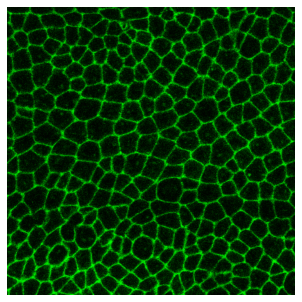

<Figure size 432x288 with 0 Axes>

(512, 512, 3)
first mask image


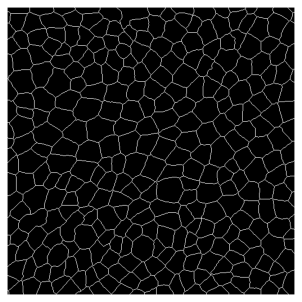

<Figure size 432x288 with 0 Axes>

(512, 512, 3)


<font color="green">Everything seems fine, please move on to next step.</font>

In [16]:
#@title <-- Press Run

# print(folder_train_originals.path)
# print(folder_train_segmentation.path)

originals_list = DataGenerator.get_list_of_images(folder_train_originals.path)
# print(originals_list)
segmented_list = DataGenerator.get_list_of_images(folder_train_segmentation.path)
# print(segmented_list)    
print('originals n=',len(originals_list), 'segmented images n=', len(segmented_list))

first_orig = None
first_mask = None

if len(originals_list) > 0 and len(segmented_list)> 0 and len(originals_list) == len(segmented_list):
  try:
    print('first original image')
    first_orig = Img(originals_list[0])
    first_orig.pop()
    print(first_orig.shape)
    print('first mask image')
    first_mask = Img(segmented_list[0])
    first_mask.pop()
    print(first_mask.shape)
  
    printmd('<font color="green">Everything seems fine, please move on to next step.</font>')
  except:
    printmd('<font color="red">Problems detected. The first image(s) could not be loaded. Please check your files and repeat steps 11 to 13.</font>')    
else:
  if len(originals_list) != len(segmented_list):
    printmd('<font color="red">Problems detected. There seems to be a discrepancy between the number of original images and their corresponding segmentation. You may proceed but training will most likely fail. It is recommended you repeat steps 11 and 12 to change folders or check your files.</font>')
  else:
    printmd('<font color="red">Problems detected. A folder seems empty. Please repeat steps 11 to 13.</font>')


# Step 14
- Please run the cell below to define normalization and clip model input images (original images)

In [17]:
#@title <-- Press Run

# Normalization for orig data

info_label_orig=widgets.Label('If you don\'t know what to do, just leave pamaters unchanged and move on to next step.')

# if image has no or 1 channel then ignore COI
channels_orig = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
if first_orig is not None:
  if first_orig.has_c():
    channels_orig = []
    for c in range(first_orig.get_dimension('c')):
      channels_orig.append(c)
  else:
    channels_orig = [0]

channel_COI_orig = widgets.Dropdown(
    placeholder='Choose a channel of interest',
    options=channels_orig,
    description='Channel of interest (COI)',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

rule_reduc_orig = widgets.Dropdown(
    placeholder='Rule to reduce nb of channels (if needed)',
    options=['copy the COI to all available channels','force copy the COI to all available channels even if nb of channels is ok','remove extra channels'],
    description='Rule to reduce nb of channels (if needed)',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

rule_aug_orig = widgets.Dropdown(
    placeholder='Rule to increase nb of channels (if needed)',
    options=['copy the COI to all channels', 'force copy the COI to all available channels even if nb of channels is ok', 'copy the COI to missing channels only', 'add empty channels (0 filled)'],
    description='Rule to increase nb of channels (if needed)',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)


# TODO REMOVE LINE BELOW AND UPDATE LIBRARY!!!!
# ̣̣̣!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Img.clipping_methods = ['ignore outliers', '+', '+/-', '-']

# list of available normalization methods
# print(Img.normalization_methods)
# Img.normalization_ranges =[[0, 1], [-1, 1]]
# print('a',Img.normalization_ranges)
ranges = Img.normalization_ranges.copy()
# print(ranges)

for n,r in enumerate(ranges):
  # print(r,n, str(r))
  ranges[n]=str(r)

# print(ranges)

normalization_methods_orig = widgets.Dropdown(
    # value='Rescaling (min-max normalization)',
    placeholder='Normalization',
    options=Img.normalization_methods,
    description='Normalization method',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)
normalization_range_orig = widgets.Dropdown(
    # value='[0, 1]',
    placeholder='Range',
    options=ranges,
    description='Normalization range',
    ensure_option=True,
    disabled=False,
    # layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)
clipping_methods_orig = widgets.Dropdown(
    placeholder='Clipping outliers',
    options=Img.clipping_methods,
    description='clip intensity',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

per_channel_orig = widgets.Checkbox(True,
                       description='Per channel normalization',
                       style={'description_width': 'initial'}
)

cliprange_orig = widgets.FloatSlider(description='range (clipping)', value=0.05, min=0, max=0.25, step=0.01,style={'description_width': 'initial'})

# display(per_channel)
# def changed(b):
#     print(b)

# per_channel.observe(changed)

# wdgts = []
# ui = widgets.VBox(wdgts)
# display(ui)

invert_orig = widgets.Checkbox(False,
                       description='Negative/invert intensity',
                       style={'description_width': 'initial'}
)


# print(range_value)
# print(per_channel.value) #recover checkbox value

ui = widgets.VBox([info_label_orig, channel_COI_orig, rule_reduc_orig, rule_aug_orig, normalization_methods_orig, normalization_range_orig, per_channel_orig, clipping_methods_orig,  cliprange_orig, invert_orig])
display(ui)



# Step 15
- Please run the cell below to define normalization and pre process segmented images (mask images)

In [22]:
#@title <-- Press Run

# Normalization for masks
# avec plus ou moins de preprocess style dilat

info_label_mask=widgets.Label('If you don\'t know what to do, just leave pamaters unchanged and move on to next step.')

# if image has no or 1 channel then ignore COI
channels_mask = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
if first_mask is not None:
  if first_mask.has_c():
    channels_mask = []
    for c in range(first_mask.get_dimension('c')):
      channels_mask.append(c)
  else:
    channels_mask = [0]

channel_COI_mask = widgets.Dropdown(
    placeholder='Choose a channel of interest',
    options=channels_mask,
    description='Channel of interest (COI)',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

rule_reduc_mask = widgets.Dropdown(
    placeholder='Rule to reduce nb of channels (if needed)',
    options=['copy the COI to all available channels','force copy the COI to all available channels even if nb of channels is ok','remove extra channels'],
    description='Rule to reduce nb of channels (if needed)',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

rule_aug_mask = widgets.Dropdown(
    placeholder='Rule to increase nb of channels (if needed)',
    options=['copy the COI to all channels', 'force copy the COI to all available channels even if nb of channels is ok', 'copy the COI to missing channels only', 'add empty channels (0 filled)'],
    description='Rule to increase nb of channels (if needed)',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)


# TODO REMOVE LINE BELOW AND UPDATE LIBRARY!!!!
# ̣̣̣!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Img.clipping_methods = ['ignore outliers', '+', '+/-', '-']

# list of available normalization methods
# print(Img.normalization_methods)
# Img.normalization_ranges =[[0, 1], [-1, 1]]
# print('a',Img.normalization_ranges)
ranges = Img.normalization_ranges.copy()
# print(ranges)

for n,r in enumerate(ranges):
  # print(r,n, str(r))
  ranges[n]=str(r)

# print(ranges)

normalization_methods_mask = widgets.Dropdown(
    # value='Rescaling (min-max normalization)',
    placeholder='Normalization',
    options=Img.normalization_methods,
    description='Normalization method',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)
normalization_range_mask = widgets.Dropdown(
    # value='[0, 1]',
    placeholder='Range',
    options=ranges,
    description='Normalization range',
    ensure_option=True,
    disabled=False,
    # layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

per_channel_mask = widgets.Checkbox(True,
                       description='Per channel normalization',
                       style={'description_width': 'initial'}
)

remove_n_border_mask_pixels = widgets.IntSlider(description='Remove border pixels', value=0, min=0, max=10, step=1,style={'description_width': 'initial'})
mask_dilations = widgets.IntSlider(description='Dilation', value=0, min=0, max=10, step=1,style={'description_width': 'initial'})

ui = widgets.VBox([info_label_mask, channel_COI_mask, rule_reduc_mask, rule_aug_mask, normalization_methods_mask, normalization_range_mask, per_channel_mask, remove_n_border_mask_pixels,mask_dilations])
display(ui)



# Step 16
- Please run the cell below to set training parameters

In [19]:
#@title <-- Press Run


# input_normalization = {'method': 'Rescaling (min-max normalization)', 'range': [0, 1],
                          #  'individual_channels': True}

# now the batch size and alike parameters
batch_size_slider = widgets.IntSlider(description='Batch size', value=16, min=1, max=256, step=1,style={'description_width': 'initial'})
epochs_slider = widgets.IntSlider(description='Number of epochs', value=100, min=5, max=1000, step=1,style={'description_width': 'initial'})
keep_slider = widgets.IntSlider(description='Keep best models', value=5, min=-1, max=1000, step=1,style={'description_width': 'initial'})
# assume full set at every step

wdgts = [batch_size_slider, epochs_slider, keep_slider]
ui = widgets.VBox(wdgts)
display(ui)

# Step 17
- Please run the cell to set the tiling parameters (to reduce memory usage)

In [25]:
#@title <-- Press Run

test_boolean = True # True # I can have a conditional GUI in fact
wdgts = []

input_shape = deepTA.get_inputs_shape()
output_shape = deepTA.get_outputs_shape()

# so far assume model has one entry and one output maybe allow several inputs and outputs later
# print('model input shape', input_shape[0])
# print('model output shape', output_shape[0])

input_val_width = 128
input_val_height = 128
if input_shape[0][-2] is not None:
  # print(input_shape[0][-2]) # default tile width
  input_val_width=input_shape[0][-2]
  test_boolean = False
if input_shape[0][-3] is not None:
  # print(input_shape[0][-3]) # default tile height
  input_val_height=input_shape[0][-3]
  test_boolean = False

tile_width_slider = widgets.IntSlider(description='tile width', value=input_val_width, min=16, max=1024, step=2,style={'description_width': 'initial'})
wdgts.append(tile_width_slider)
tile_height_slider = widgets.IntSlider(description='tile height', value=input_val_height, min=16, max=1024, step=2,style={'description_width': 'initial'})
wdgts.append(tile_height_slider)

# now the batch size and alike parameters
if not test_boolean:
  tile_width_slider.disabled = True
  tile_height_slider.disabled = True
  printmd('<font color="green">input width and height is already defined with the model, please move on to next step</font>')
else:
  ui = widgets.VBox(wdgts)
  display(ui)


# Step 18
- Please run the cell below to set the data augmentation parameters

In [21]:
#@title <-- Press Run

# need be defined here to avoid erase if people relaunch stuff and allow repopulate it maybe change this
augmentations = []

from epyseg.deeplearning.augmentation.generators.data import DataGenerator
import json

# maybe make this dynamic ??? because I need add data augs --> just give it a try but dynamic would be good ideally
types_of_augmentations = list(DataGenerator.augmentation_types_and_ranges.keys())
# print(types_of_augmentations)
# faire un add et ajouter les augs à une liste puis la passer au truc suivant (est ce que je permet de changer les parametres ou pas???? peut etre une autre fois, je pense qu'il faut que ce truc soit dynamique avec du interact...)
augmentation_drop = widgets.Dropdown(
    value='None',
    placeholder='Data augmentation',
    options=types_of_augmentations,
    description='Data augmentation',
    ensure_option=True,
    disabled=False,
    # layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

# TODO need a add button that adds to current augs and maybe a reset one too
# need a list to have all the augs at once



list1 = widgets.Select(
    options=augmentations,
    description='Selected augmentations:',
    disabled=False,
    style={'description_width': 'initial'}
)

button0 = widgets.Button(
    description='Add augmentation',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Add',
    icon='check',
    style={'description_width': 'initial'}
)

remove = widgets.Button(description='Remove')
def on_remove_clicked(_):
      # "linking function with output"
      # with out:
          # what happens when we press the button
          # clear_output()
          # print('Something happens!')
          try:
            augmentations.remove(list1.value)
            list1.options = augmentations
          except:
            pass

remove.on_click(on_remove_clicked)

data_aug_range_rate = widgets.FloatSlider(description='range/rate', value=0.05, min=0, max=0.25, step=0.01,style={'description_width': 'initial'}, disabled = True)

def on_combobox_changed(x):
    default_value = DataGenerator.augmentation_types_and_ranges[augmentation_drop.value]
    show = default_value is not None
    data_aug_range_rate.disabled = not show
    if show:
      data_aug_range_rate.max = default_value[1]
      data_aug_range_rate.min = default_value[0]
      data_aug_range_rate.value = default_value[2]

interact(on_combobox_changed, x=augmentation_drop);

add = widgets.Button(description='Add')
def on_button_clicked(_):
          aug_as_text = ''
          type = augmentation_drop.value
          if type == 'None':
              aug_as_text = json.dumps({'type': None})
          else:
              if data_aug_range_rate.disabled:
                  aug_as_text= json.dumps({'type': type})
              else:
                # no need to send value if 0
                if data_aug_range_rate.value == 0:
                    aug_as_text = json.dumps({'type': None})
                aug_as_text = json.dumps({'type':type, 'value':data_aug_range_rate.value})


          augmentations.append(aug_as_text)
          list1.options = augmentations

# linking button and function together using a button's method
add.on_click(on_button_clicked)

ui = widgets.VBox([ list1, data_aug_range_rate, add,remove])#augmentation_drop,
display(ui)


interactive(children=(Dropdown(description='Data augmentation', options=('None', 'shear', 'zoom', 'rotate', 'r…

# Step 19
- Please run the cell below to train the model

In [26]:
#@title <-- Press Run

train_parameters = {}
dataset= {}

items = []
# reconvert json string to dict
for aug in list1.options:
    items.append(json.loads(aug))
train_parameters['augmentations'] = items

train_parameters['input_normalization'] = {'method': normalization_methods_orig.value,
                                           'individual_channels': per_channel_orig.value,
                                           'range': normalization_range_orig.value}
train_parameters['output_normalization'] = {'method': normalization_methods_mask.value,
                                           'individual_channels': per_channel_mask.value,
                                           'range': normalization_range_mask.value}                                           
dataset['inputs'] = [folder_train_originals.path]
dataset['outputs'] = [folder_train_segmentation.path]

def get_clip_by_freq():
      if 'ignore' in clipping_methods_orig.value:
          return {'lower_cutoff': None, 'upper_cutoff': None,
                  'channel_mode': per_channel_orig.value}
      elif clipping_methods_orig.value == '+':
          return {'lower_cutoff': None, 'upper_cutoff': cliprange_orig.value,
                  'channel_mode': per_channel_orig.value}
      elif clipping_methods_orig.value == '-':
          return {'lower_cutoff': cliprange_orig.value, 'upper_cutoff': None,
                  'channel_mode': per_channel_orig.value}
      else:
        #  '/' in clipping_methods_orig.value:
          return {'lower_cutoff': cliprange_orig.value, 'upper_cutoff': cliprange_orig.value,
                  'channel_mode': per_channel_orig.value}

train_parameters['clip_by_frequency'] = get_clip_by_freq()

dataset['input_channel_reduction_rule'] =rule_reduc_orig.value
dataset['input_channel_augmentation_rule'] =rule_aug_orig.value
dataset['input_channel_of_interest'] =channel_COI_orig.value
dataset['output_channel_reduction_rule'] =rule_reduc_mask.value
dataset['output_channel_augmentation_rule'] =rule_aug_mask.value
dataset['output_channel_of_interest'] =channel_COI_mask.value
train_parameters['epochs'] = epochs_slider.value
train_parameters['keep_n_best'] = keep_slider.value
train_parameters['steps_per_epoch'] = -1 # always full set maybe change this some day though
train_parameters['shuffle'] = False
train_parameters['batch_size'] = batch_size_slider.value
train_parameters['batch_size_auto_adjust'] = True
train_parameters['validation_split'] = 0
dataset['crop_parameters'] = None #TODO maybe some day...
dataset['remove_n_border_mask_pixels'] = remove_n_border_mask_pixels.value
dataset['mask_dilations'] = mask_dilations.value
dataset['invert'] = invert_orig.value
train_parameters['datasets'] = [dataset]

train_parameters['default_input_tile_width'] = tile_width_slider.value
train_parameters['default_input_tile_height'] = tile_height_slider.value
train_parameters['default_output_tile_width'] = tile_width_slider.value
train_parameters['default_output_tile_height'] = tile_height_slider.value

if True:

  batch_size = batch_size_slider.value #16 # TODO specify that here too
  NB_EPOCHS = epochs_slider.value #180  # 80 # 100 # 10 # 150
  deepTA.get_loaded_model_params()
  metaAugmenter = MetaAugmenter(input_shape=input_shape, output_shape=output_shape, **train_parameters)

  metaAugmenter.appendDatasets(**train_parameters)
  deepTA.train(metaAugmenter, progress_callback=None, **train_parameters)

  # TODO save model here as pb and as JSON, pb is better as it has the compiler, etc...
  deepTA.saveModel()
  deepTA.saveAsJsonWithWeights()
  deepTA.plot_graph(deepTA.model._name + '_graph.png')


0.001
name Adam
lr 0.001
lr2 0.0
lr3 0
lr4 0.9
lr5 0.999


INFO - 2020-06-23 08:01:44,497 - deepl.py - train - line 887 - train dataset batches: 2
validation dataset batches: 0



{'_use_locking': True, '_name': 'Adam', '_hyper': {'learning_rate': <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>, 'decay': <tf.Variable 'decay:0' shape=() dtype=float32, numpy=0.0>, 'beta_1': <tf.Variable 'beta_1:0' shape=() dtype=float32, numpy=0.9>, 'beta_2': <tf.Variable 'beta_2:0' shape=() dtype=float32, numpy=0.999>}, '_slots': {'block1_conv1/kernel_5': {'m': <tf.Variable 'Adam/block1_conv1/kernel/m:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

INFO - 2020-06-23 08:01:44,684 - saver.py - on_epoch_begin - line 110 - 0.0%



Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.9553 - iou_score: 0.0447

INFO - 2020-06-23 08:01:53,611 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.24797212744443994 hour(s)

INFO - 2020-06-23 08:01:53,614 - saver.py - on_epoch_end - line 319 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.9553 - iou_score: 0.0447


INFO - 2020-06-23 08:01:54,995 - saver.py - on_epoch_begin - line 110 - 1.0%



Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.9511 - iou_score: 0.0489

INFO - 2020-06-23 08:01:56,570 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.04332966195249981 hour(s)

INFO - 2020-06-23 08:01:56,580 - saver.py - on_epoch_end - line 238 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.9511 - iou_score: 0.0489


INFO - 2020-06-23 08:01:57,972 - saver.py - on_epoch_begin - line 110 - 2.0%



Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.9445 - iou_score: 0.0555

INFO - 2020-06-23 08:01:59,526 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.04232167044000082 hour(s)

INFO - 2020-06-23 08:01:59,539 - saver.py - on_epoch_end - line 238 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.9445 - iou_score: 0.0555


INFO - 2020-06-23 08:02:00,903 - saver.py - on_epoch_begin - line 110 - 3.0%



Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 0.9391 - iou_score: 0.0609

INFO - 2020-06-23 08:02:02,475 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.04236101986500052 hour(s)

INFO - 2020-06-23 08:02:02,497 - saver.py - on_epoch_end - line 238 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.9391 - iou_score: 0.0609


INFO - 2020-06-23 08:02:04,322 - saver.py - on_epoch_begin - line 110 - 4.0%



Epoch 5/100
2/2 [==============================] - ETA: 0s - loss: 0.9272 - iou_score: 0.0728

INFO - 2020-06-23 08:02:05,870 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.04128026970667027 hour(s)

INFO - 2020-06-23 08:02:05,886 - saver.py - on_epoch_end - line 238 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.9272 - iou_score: 0.0728


INFO - 2020-06-23 08:02:07,231 - saver.py - on_epoch_begin - line 110 - 5.0%



Epoch 6/100
2/2 [==============================] - ETA: 0s - loss: 0.9203 - iou_score: 0.0797

INFO - 2020-06-23 08:02:08,779 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.040853799788887576 hour(s)

INFO - 2020-06-23 08:02:08,833 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.9203 - iou_score: 0.0797


INFO - 2020-06-23 08:02:10,166 - saver.py - on_epoch_begin - line 110 - 6.0%



Epoch 7/100
2/2 [==============================] - ETA: 0s - loss: 0.9189 - iou_score: 0.0811

INFO - 2020-06-23 08:02:11,719 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.040534545867217275 hour(s)

INFO - 2020-06-23 08:02:11,750 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.9189 - iou_score: 0.0811


INFO - 2020-06-23 08:02:13,193 - saver.py - on_epoch_begin - line 110 - 7.000000000000001%



Epoch 8/100
2/2 [==============================] - ETA: 0s - loss: 0.9126 - iou_score: 0.0874

INFO - 2020-06-23 08:02:14,753 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.04029985055416565 hour(s)

INFO - 2020-06-23 08:02:14,784 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.9126 - iou_score: 0.0874


INFO - 2020-06-23 08:02:16,150 - saver.py - on_epoch_begin - line 110 - 8.0%



Epoch 9/100
2/2 [==============================] - ETA: 0s - loss: 0.9036 - iou_score: 0.0964

INFO - 2020-06-23 08:02:17,698 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03955954091999729 hour(s)

INFO - 2020-06-23 08:02:17,731 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 7s 3s/step - loss: 0.9036 - iou_score: 0.0964


INFO - 2020-06-23 08:02:23,473 - saver.py - on_epoch_begin - line 110 - 9.0%



Epoch 10/100
2/2 [==============================] - ETA: 0s - loss: 0.8947 - iou_score: 0.1053

INFO - 2020-06-23 08:02:25,095 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.04098536654333385 hour(s)

INFO - 2020-06-23 08:02:25,137 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 2s/step - loss: 0.8947 - iou_score: 0.1053


INFO - 2020-06-23 08:02:27,729 - saver.py - on_epoch_begin - line 110 - 10.0%



Epoch 11/100
2/2 [==============================] - ETA: 0s - loss: 0.8917 - iou_score: 0.1083

INFO - 2020-06-23 08:02:29,285 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.038910577724999486 hour(s)

INFO - 2020-06-23 08:02:29,338 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 2s/step - loss: 0.8917 - iou_score: 0.1083


INFO - 2020-06-23 08:02:31,918 - saver.py - on_epoch_begin - line 110 - 11.0%



Epoch 12/100
2/2 [==============================] - ETA: 0s - loss: 0.8847 - iou_score: 0.1153

INFO - 2020-06-23 08:02:33,476 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.038522457869727245 hour(s)

INFO - 2020-06-23 08:02:33,503 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 5s 3s/step - loss: 0.8847 - iou_score: 0.1153


INFO - 2020-06-23 08:02:37,936 - saver.py - on_epoch_begin - line 110 - 12.0%



Epoch 13/100
2/2 [==============================] - ETA: 0s - loss: 0.8823 - iou_score: 0.1177

INFO - 2020-06-23 08:02:39,492 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03803786284222244 hour(s)

INFO - 2020-06-23 08:02:42,139 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 9s 5s/step - loss: 0.8823 - iou_score: 0.1177


INFO - 2020-06-23 08:02:48,101 - saver.py - on_epoch_begin - line 110 - 13.0%



Epoch 14/100
2/2 [==============================] - ETA: 0s - loss: 0.8698 - iou_score: 0.1302

INFO - 2020-06-23 08:02:49,657 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03760445048583392 hour(s)

INFO - 2020-06-23 08:02:49,700 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 2s/step - loss: 0.8698 - iou_score: 0.1302


INFO - 2020-06-23 08:02:52,200 - saver.py - on_epoch_begin - line 110 - 14.000000000000002%



Epoch 15/100
2/2 [==============================] - ETA: 0s - loss: 0.8592 - iou_score: 0.1408

INFO - 2020-06-23 08:02:53,766 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03740471451166589 hour(s)

INFO - 2020-06-23 08:02:53,798 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.8592 - iou_score: 0.1408


INFO - 2020-06-23 08:02:55,487 - saver.py - on_epoch_begin - line 110 - 15.0%



Epoch 16/100
2/2 [==============================] - ETA: 0s - loss: 0.8529 - iou_score: 0.1471

INFO - 2020-06-23 08:02:57,060 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03712501253333408 hour(s)

INFO - 2020-06-23 08:02:57,077 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 4s 2s/step - loss: 0.8529 - iou_score: 0.1471


INFO - 2020-06-23 08:03:00,448 - saver.py - on_epoch_begin - line 110 - 16.0%



Epoch 17/100
2/2 [==============================] - ETA: 0s - loss: 0.8386 - iou_score: 0.1614

INFO - 2020-06-23 08:03:02,003 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.036298169880000536 hour(s)

INFO - 2020-06-23 08:03:02,039 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 11s 6s/step - loss: 0.8386 - iou_score: 0.1614


INFO - 2020-06-23 08:03:12,616 - saver.py - on_epoch_begin - line 110 - 17.0%



Epoch 18/100
2/2 [==============================] - ETA: 0s - loss: 0.8358 - iou_score: 0.1642

INFO - 2020-06-23 08:03:14,228 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03719245387277807 hour(s)

INFO - 2020-06-23 08:03:14,255 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.8358 - iou_score: 0.1642


INFO - 2020-06-23 08:03:16,011 - saver.py - on_epoch_begin - line 110 - 18.0%



Epoch 19/100
2/2 [==============================] - ETA: 0s - loss: 0.8257 - iou_score: 0.1743

INFO - 2020-06-23 08:03:17,574 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03559823280277897 hour(s)

INFO - 2020-06-23 08:03:17,601 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.8257 - iou_score: 0.1743


INFO - 2020-06-23 08:03:19,249 - saver.py - on_epoch_begin - line 110 - 19.0%



Epoch 20/100
2/2 [==============================] - ETA: 0s - loss: 0.7991 - iou_score: 0.2009

INFO - 2020-06-23 08:03:20,797 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03484597225499897 hour(s)

INFO - 2020-06-23 08:03:20,827 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 12s 6s/step - loss: 0.7991 - iou_score: 0.2009


INFO - 2020-06-23 08:03:31,560 - saver.py - on_epoch_begin - line 110 - 20.0%



Epoch 21/100
2/2 [==============================] - ETA: 0s - loss: 0.8003 - iou_score: 0.1997

INFO - 2020-06-23 08:03:33,118 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03461198544444212 hour(s)

INFO - 2020-06-23 08:03:33,143 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 3s 1s/step - loss: 0.8003 - iou_score: 0.1997


INFO - 2020-06-23 08:03:34,935 - saver.py - on_epoch_begin - line 110 - 21.0%



Epoch 22/100
2/2 [==============================] - ETA: 0s - loss: 0.7689 - iou_score: 0.2311

INFO - 2020-06-23 08:03:36,487 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.034073258595833836 hour(s)

INFO - 2020-06-23 08:03:36,528 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 2s/step - loss: 0.7689 - iou_score: 0.2311


INFO - 2020-06-23 08:03:39,060 - saver.py - on_epoch_begin - line 110 - 22.0%



Epoch 23/100
2/2 [==============================] - ETA: 0s - loss: 0.7553 - iou_score: 0.2447

INFO - 2020-06-23 08:03:40,619 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.033795194983335934 hour(s)

INFO - 2020-06-23 08:03:40,645 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 8s 4s/step - loss: 0.7553 - iou_score: 0.2447


INFO - 2020-06-23 08:03:48,095 - saver.py - on_epoch_begin - line 110 - 23.0%



Epoch 24/100
2/2 [==============================] - ETA: 0s - loss: 0.7252 - iou_score: 0.2748

INFO - 2020-06-23 08:03:49,653 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03330699119610996 hour(s)

INFO - 2020-06-23 08:03:49,691 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.7252 - iou_score: 0.2748


INFO - 2020-06-23 08:03:51,629 - saver.py - on_epoch_begin - line 110 - 24.0%



Epoch 25/100
2/2 [==============================] - ETA: 0s - loss: 0.7297 - iou_score: 0.2703

INFO - 2020-06-23 08:03:53,184 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03283926918888837 hour(s)

INFO - 2020-06-23 08:03:53,211 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 8s 4s/step - loss: 0.7297 - iou_score: 0.2703


INFO - 2020-06-23 08:04:00,830 - saver.py - on_epoch_begin - line 110 - 25.0%



Epoch 26/100
2/2 [==============================] - ETA: 0s - loss: 0.7021 - iou_score: 0.2979

INFO - 2020-06-23 08:04:02,468 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.034120747499997606 hour(s)

INFO - 2020-06-23 08:04:02,504 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 7s 4s/step - loss: 0.7021 - iou_score: 0.2979


INFO - 2020-06-23 08:04:08,831 - saver.py - on_epoch_begin - line 110 - 26.0%



Epoch 27/100
2/2 [==============================] - ETA: 0s - loss: 0.6808 - iou_score: 0.3192

INFO - 2020-06-23 08:04:10,379 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03181282672777772 hour(s)

INFO - 2020-06-23 08:04:10,408 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 4s 2s/step - loss: 0.6808 - iou_score: 0.3192


INFO - 2020-06-23 08:04:13,388 - saver.py - on_epoch_begin - line 110 - 27.0%



Epoch 28/100
2/2 [==============================] - ETA: 0s - loss: 0.6624 - iou_score: 0.3376

INFO - 2020-06-23 08:04:14,953 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.031723718080557496 hour(s)

INFO - 2020-06-23 08:04:14,979 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.6624 - iou_score: 0.3376


INFO - 2020-06-23 08:04:16,400 - saver.py - on_epoch_begin - line 110 - 28.000000000000004%



Epoch 29/100
2/2 [==============================] - ETA: 0s - loss: 0.6486 - iou_score: 0.3514

INFO - 2020-06-23 08:04:17,959 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.03118292965999899 hour(s)

INFO - 2020-06-23 08:04:17,985 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 8s 4s/step - loss: 0.6486 - iou_score: 0.3514


INFO - 2020-06-23 08:04:25,460 - saver.py - on_epoch_begin - line 110 - 28.999999999999996%



Epoch 30/100
2/2 [==============================] - ETA: 0s - loss: 0.6359 - iou_score: 0.3641

INFO - 2020-06-23 08:04:27,021 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.030785734604169633 hour(s)

INFO - 2020-06-23 08:04:27,048 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.6359 - iou_score: 0.3641


INFO - 2020-06-23 08:04:28,880 - saver.py - on_epoch_begin - line 110 - 30.0%



Epoch 31/100
2/2 [==============================] - ETA: 0s - loss: 0.6177 - iou_score: 0.3823

INFO - 2020-06-23 08:04:30,431 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.030159394611111643 hour(s)

INFO - 2020-06-23 08:04:33,633 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 5s 3s/step - loss: 0.6177 - iou_score: 0.3823


INFO - 2020-06-23 08:04:35,052 - saver.py - on_epoch_begin - line 110 - 31.0%



Epoch 32/100
2/2 [==============================] - ETA: 0s - loss: 0.5973 - iou_score: 0.4027

INFO - 2020-06-23 08:04:36,603 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02973488365166683 hour(s)

INFO - 2020-06-23 08:04:36,636 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 5s 2s/step - loss: 0.5973 - iou_score: 0.4027


INFO - 2020-06-23 08:04:40,462 - saver.py - on_epoch_begin - line 110 - 32.0%



Epoch 33/100
2/2 [==============================] - ETA: 0s - loss: 0.5860 - iou_score: 0.4140

INFO - 2020-06-23 08:04:42,022 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02946957672666738 hour(s)

INFO - 2020-06-23 08:04:42,048 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 9s 5s/step - loss: 0.5860 - iou_score: 0.4140


INFO - 2020-06-23 08:04:50,513 - saver.py - on_epoch_begin - line 110 - 33.0%



Epoch 34/100
2/2 [==============================] - ETA: 0s - loss: 0.5549 - iou_score: 0.4451

INFO - 2020-06-23 08:04:52,142 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.030312646594443386 hour(s)

INFO - 2020-06-23 08:04:52,167 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.5549 - iou_score: 0.4451


INFO - 2020-06-23 08:04:54,023 - saver.py - on_epoch_begin - line 110 - 34.0%



Epoch 35/100
2/2 [==============================] - ETA: 0s - loss: 0.5549 - iou_score: 0.4451

INFO - 2020-06-23 08:04:55,587 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.028657161408333423 hour(s)

INFO - 2020-06-23 08:04:55,624 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 10s 5s/step - loss: 0.5549 - iou_score: 0.4451


INFO - 2020-06-23 08:05:04,644 - saver.py - on_epoch_begin - line 110 - 35.0%



Epoch 36/100
2/2 [==============================] - ETA: 0s - loss: 0.5331 - iou_score: 0.4669

INFO - 2020-06-23 08:05:06,194 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.027996968115274336 hour(s)

INFO - 2020-06-23 08:05:06,227 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.5331 - iou_score: 0.4669


INFO - 2020-06-23 08:05:08,078 - saver.py - on_epoch_begin - line 110 - 36.0%



Epoch 37/100
2/2 [==============================] - ETA: 0s - loss: 0.5366 - iou_score: 0.4634

INFO - 2020-06-23 08:05:09,627 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.027543378400001126 hour(s)

INFO - 2020-06-23 08:05:10,854 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 3s 2s/step - loss: 0.5366 - iou_score: 0.4634


INFO - 2020-06-23 08:05:12,324 - saver.py - on_epoch_begin - line 110 - 37.0%



Epoch 38/100
2/2 [==============================] - ETA: 0s - loss: 0.5070 - iou_score: 0.4930

INFO - 2020-06-23 08:05:13,870 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02706615037000006 hour(s)

INFO - 2020-06-23 08:05:13,904 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 7s 3s/step - loss: 0.5070 - iou_score: 0.4930


INFO - 2020-06-23 08:05:20,056 - saver.py - on_epoch_begin - line 110 - 38.0%



Epoch 39/100
2/2 [==============================] - ETA: 0s - loss: 0.5150 - iou_score: 0.4850

INFO - 2020-06-23 08:05:21,728 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.028790421146112397 hour(s)

INFO - 2020-06-23 08:05:21,758 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 3s 2s/step - loss: 0.5150 - iou_score: 0.4850


INFO - 2020-06-23 08:05:24,194 - saver.py - on_epoch_begin - line 110 - 39.0%



Epoch 40/100
2/2 [==============================] - ETA: 0s - loss: 0.5275 - iou_score: 0.4725

INFO - 2020-06-23 08:05:25,746 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.026292601876944495 hour(s)

INFO - 2020-06-23 08:05:29,405 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 6s 3s/step - loss: 0.5275 - iou_score: 0.4725


INFO - 2020-06-23 08:05:30,987 - saver.py - on_epoch_begin - line 110 - 40.0%



Epoch 41/100
2/2 [==============================] - ETA: 0s - loss: 0.4835 - iou_score: 0.5165

INFO - 2020-06-23 08:05:32,535 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02580069089999976 hour(s)

INFO - 2020-06-23 08:05:32,566 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 10s 5s/step - loss: 0.4835 - iou_score: 0.5165


INFO - 2020-06-23 08:05:41,764 - saver.py - on_epoch_begin - line 110 - 41.0%



Epoch 42/100
2/2 [==============================] - ETA: 0s - loss: 0.4873 - iou_score: 0.5127

INFO - 2020-06-23 08:05:43,404 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02688769708722513 hour(s)

INFO - 2020-06-23 08:05:43,424 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 3s 2s/step - loss: 0.4873 - iou_score: 0.5127


INFO - 2020-06-23 08:05:46,002 - saver.py - on_epoch_begin - line 110 - 42.0%



Epoch 43/100
2/2 [==============================] - ETA: 0s - loss: 0.4739 - iou_score: 0.5261

INFO - 2020-06-23 08:05:47,559 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.025077618162776566 hour(s)

INFO - 2020-06-23 08:05:47,585 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.4739 - iou_score: 0.5261


INFO - 2020-06-23 08:05:49,165 - saver.py - on_epoch_begin - line 110 - 43.0%



Epoch 44/100
2/2 [==============================] - ETA: 0s - loss: 0.4738 - iou_score: 0.5262

INFO - 2020-06-23 08:05:50,716 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02455801029249888 hour(s)

INFO - 2020-06-23 08:05:50,742 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 10s 5s/step - loss: 0.4738 - iou_score: 0.5262


INFO - 2020-06-23 08:06:00,356 - saver.py - on_epoch_begin - line 110 - 44.0%



Epoch 45/100
2/2 [==============================] - ETA: 0s - loss: 0.4697 - iou_score: 0.5303

INFO - 2020-06-23 08:06:01,910 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.024173633291112915 hour(s)

INFO - 2020-06-23 08:06:01,934 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.4697 - iou_score: 0.5303


INFO - 2020-06-23 08:06:03,344 - saver.py - on_epoch_begin - line 110 - 45.0%



Epoch 46/100
2/2 [==============================] - ETA: 0s - loss: 0.4634 - iou_score: 0.5366

INFO - 2020-06-23 08:06:04,899 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02376007852777775 hour(s)

INFO - 2020-06-23 08:06:04,928 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 8s 4s/step - loss: 0.4634 - iou_score: 0.5366


INFO - 2020-06-23 08:06:12,480 - saver.py - on_epoch_begin - line 110 - 46.0%



Epoch 47/100
2/2 [==============================] - ETA: 0s - loss: 0.4537 - iou_score: 0.5463

INFO - 2020-06-23 08:06:14,038 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02336518296000122 hour(s)

INFO - 2020-06-23 08:06:14,083 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 5s 3s/step - loss: 0.4537 - iou_score: 0.5463


INFO - 2020-06-23 08:06:18,509 - saver.py - on_epoch_begin - line 110 - 47.0%



Epoch 48/100
2/2 [==============================] - ETA: 0s - loss: 0.4450 - iou_score: 0.5550

INFO - 2020-06-23 08:06:20,065 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.022910307114445725 hour(s)

INFO - 2020-06-23 08:06:20,090 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.4450 - iou_score: 0.5550


INFO - 2020-06-23 08:06:21,513 - saver.py - on_epoch_begin - line 110 - 48.0%



Epoch 49/100
2/2 [==============================] - ETA: 0s - loss: 0.4383 - iou_score: 0.5617

INFO - 2020-06-23 08:06:26,084 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.0660242571155575 hour(s)

INFO - 2020-06-23 08:06:26,106 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 7s 3s/step - loss: 0.4383 - iou_score: 0.5617


INFO - 2020-06-23 08:06:29,018 - saver.py - on_epoch_begin - line 110 - 49.0%



Epoch 50/100
2/2 [==============================] - ETA: 0s - loss: 0.4485 - iou_score: 0.5515

INFO - 2020-06-23 08:06:30,574 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.0220485075241686 hour(s)

INFO - 2020-06-23 08:06:30,594 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 3s 2s/step - loss: 0.4485 - iou_score: 0.5515


INFO - 2020-06-23 08:06:32,878 - saver.py - on_epoch_begin - line 110 - 50.0%



Epoch 51/100
2/2 [==============================] - ETA: 0s - loss: 0.4382 - iou_score: 0.5618

INFO - 2020-06-23 08:06:34,433 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02160238574999893 hour(s)

INFO - 2020-06-23 08:06:34,449 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 5s 3s/step - loss: 0.4382 - iou_score: 0.5618


INFO - 2020-06-23 08:06:39,006 - saver.py - on_epoch_begin - line 110 - 51.0%



Epoch 52/100
2/2 [==============================] - ETA: 0s - loss: 0.4278 - iou_score: 0.5722

INFO - 2020-06-23 08:06:40,557 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.02110927332305702 hour(s)

INFO - 2020-06-23 08:06:40,592 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 10s 5s/step - loss: 0.4278 - iou_score: 0.5722


INFO - 2020-06-23 08:06:49,854 - saver.py - on_epoch_begin - line 110 - 52.0%



Epoch 53/100
2/2 [==============================] - ETA: 0s - loss: 0.4324 - iou_score: 0.5676

INFO - 2020-06-23 08:06:51,421 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.020898921920000552 hour(s)

INFO - 2020-06-23 08:06:51,446 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 3s 2s/step - loss: 0.4324 - iou_score: 0.5676


INFO - 2020-06-23 08:06:53,963 - saver.py - on_epoch_begin - line 110 - 53.0%



Epoch 54/100
2/2 [==============================] - ETA: 0s - loss: 0.4254 - iou_score: 0.5746

INFO - 2020-06-23 08:06:55,514 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.020260075301389218 hour(s)

INFO - 2020-06-23 08:06:55,546 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.4254 - iou_score: 0.5746


INFO - 2020-06-23 08:06:57,521 - saver.py - on_epoch_begin - line 110 - 54.0%



Epoch 55/100
2/2 [==============================] - ETA: 0s - loss: 0.4341 - iou_score: 0.5659

INFO - 2020-06-23 08:06:59,073 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.019829178625555086 hour(s)

INFO - 2020-06-23 08:06:59,088 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-3.h5



2/2 [==============================] - 8s 4s/step - loss: 0.4341 - iou_score: 0.5659


INFO - 2020-06-23 08:07:05,850 - saver.py - on_epoch_begin - line 110 - 55.00000000000001%



Epoch 56/100
2/2 [==============================] - ETA: 0s - loss: 0.4288 - iou_score: 0.5712

INFO - 2020-06-23 08:07:07,407 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.01945938741249904 hour(s)

INFO - 2020-06-23 08:07:07,421 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 3s 2s/step - loss: 0.4288 - iou_score: 0.5712


INFO - 2020-06-23 08:07:10,097 - saver.py - on_epoch_begin - line 110 - 56.00000000000001%



Epoch 57/100
2/2 [==============================] - ETA: 0s - loss: 0.4281 - iou_score: 0.5719

INFO - 2020-06-23 08:07:11,714 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.01976437707444423 hour(s)

INFO - 2020-06-23 08:07:14,665 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 6s 3s/step - loss: 0.4281 - iou_score: 0.5719


INFO - 2020-06-23 08:07:17,245 - saver.py - on_epoch_begin - line 110 - 56.99999999999999%



Epoch 58/100
2/2 [==============================] - ETA: 0s - loss: 0.4173 - iou_score: 0.5827

INFO - 2020-06-23 08:07:18,798 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.018555714415556014 hour(s)

INFO - 2020-06-23 08:07:18,827 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 4s 2s/step - loss: 0.4173 - iou_score: 0.5827


INFO - 2020-06-23 08:07:22,291 - saver.py - on_epoch_begin - line 110 - 57.99999999999999%



Epoch 59/100
2/2 [==============================] - ETA: 0s - loss: 0.4159 - iou_score: 0.5841

INFO - 2020-06-23 08:07:23,835 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.018013820976667604 hour(s)

INFO - 2020-06-23 08:07:23,874 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 4s 2s/step - loss: 0.4159 - iou_score: 0.5841


INFO - 2020-06-23 08:07:27,215 - saver.py - on_epoch_begin - line 110 - 59.0%



Epoch 60/100
2/2 [==============================] - ETA: 0s - loss: 0.4183 - iou_score: 0.5817

INFO - 2020-06-23 08:07:28,776 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.01778243744194564 hour(s)

INFO - 2020-06-23 08:07:28,795 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 11s 5s/step - loss: 0.4183 - iou_score: 0.5817


INFO - 2020-06-23 08:07:38,559 - saver.py - on_epoch_begin - line 110 - 60.0%



Epoch 61/100
2/2 [==============================] - ETA: 0s - loss: 0.4083 - iou_score: 0.5917

INFO - 2020-06-23 08:07:40,119 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.01732941567777794 hour(s)

INFO - 2020-06-23 08:07:40,137 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.4083 - iou_score: 0.5917


INFO - 2020-06-23 08:07:41,965 - saver.py - on_epoch_begin - line 110 - 61.0%



Epoch 62/100
2/2 [==============================] - ETA: 0s - loss: 0.3990 - iou_score: 0.6010

INFO - 2020-06-23 08:07:43,522 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.016862175221666956 hour(s)

INFO - 2020-06-23 08:07:45,637 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 9s 5s/step - loss: 0.3990 - iou_score: 0.6010


INFO - 2020-06-23 08:07:51,864 - saver.py - on_epoch_begin - line 110 - 62.0%



Epoch 63/100
2/2 [==============================] - ETA: 0s - loss: 0.3884 - iou_score: 0.6116

INFO - 2020-06-23 08:07:53,411 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.01632928611111058 hour(s)

INFO - 2020-06-23 08:07:53,444 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.3884 - iou_score: 0.6116


INFO - 2020-06-23 08:07:55,237 - saver.py - on_epoch_begin - line 110 - 63.0%



Epoch 64/100
2/2 [==============================] - ETA: 0s - loss: 0.3900 - iou_score: 0.6100

INFO - 2020-06-23 08:07:56,795 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.016014601877778194 hour(s)

INFO - 2020-06-23 08:07:56,819 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 8s 4s/step - loss: 0.3900 - iou_score: 0.6100


INFO - 2020-06-23 08:08:04,249 - saver.py - on_epoch_begin - line 110 - 64.0%



Epoch 65/100
2/2 [==============================] - ETA: 0s - loss: 0.3774 - iou_score: 0.6226

INFO - 2020-06-23 08:08:05,875 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.016264733139998953 hour(s)

INFO - 2020-06-23 08:08:05,901 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 1s/step - loss: 0.3774 - iou_score: 0.6226


INFO - 2020-06-23 08:08:07,875 - saver.py - on_epoch_begin - line 110 - 65.0%



Epoch 66/100
2/2 [==============================] - ETA: 0s - loss: 0.3820 - iou_score: 0.6180

INFO - 2020-06-23 08:08:09,428 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.015098653198611424 hour(s)

INFO - 2020-06-23 08:08:10,452 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 3s 2s/step - loss: 0.3820 - iou_score: 0.6180


INFO - 2020-06-23 08:08:11,847 - saver.py - on_epoch_begin - line 110 - 66.0%



Epoch 67/100
2/2 [==============================] - ETA: 0s - loss: 0.3746 - iou_score: 0.6254

INFO - 2020-06-23 08:08:13,395 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.014628266372778979 hour(s)

INFO - 2020-06-23 08:08:13,420 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 5s 3s/step - loss: 0.3746 - iou_score: 0.6254


INFO - 2020-06-23 08:08:18,073 - saver.py - on_epoch_begin - line 110 - 67.0%



Epoch 68/100
2/2 [==============================] - ETA: 0s - loss: 0.3798 - iou_score: 0.6202

INFO - 2020-06-23 08:08:19,633 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.014304390035833307 hour(s)

INFO - 2020-06-23 08:08:19,652 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 5s 2s/step - loss: 0.3798 - iou_score: 0.6202


INFO - 2020-06-23 08:08:23,462 - saver.py - on_epoch_begin - line 110 - 68.0%



Epoch 69/100
2/2 [==============================] - ETA: 0s - loss: 0.3712 - iou_score: 0.6288

INFO - 2020-06-23 08:08:25,037 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.01399369215111114 hour(s)

INFO - 2020-06-23 08:08:25,065 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 6s 3s/step - loss: 0.3712 - iou_score: 0.6288


INFO - 2020-06-23 08:08:30,384 - saver.py - on_epoch_begin - line 110 - 69.0%



Epoch 70/100
2/2 [==============================] - ETA: 0s - loss: 0.3655 - iou_score: 0.6345

INFO - 2020-06-23 08:08:31,928 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.01330133498027793 hour(s)

INFO - 2020-06-23 08:08:31,967 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 9s 4s/step - loss: 0.3655 - iou_score: 0.6345


INFO - 2020-06-23 08:08:39,867 - saver.py - on_epoch_begin - line 110 - 70.0%



Epoch 71/100
2/2 [==============================] - ETA: 0s - loss: 0.3676 - iou_score: 0.6324

INFO - 2020-06-23 08:08:41,428 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.013021842249999811 hour(s)

INFO - 2020-06-23 08:08:41,451 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 7s 3s/step - loss: 0.3676 - iou_score: 0.6324


INFO - 2020-06-23 08:08:47,625 - saver.py - on_epoch_begin - line 110 - 71.0%



Epoch 72/100
2/2 [==============================] - ETA: 0s - loss: 0.3615 - iou_score: 0.6385

INFO - 2020-06-23 08:08:49,262 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.013188202689999824 hour(s)

INFO - 2020-06-23 08:08:49,286 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.3615 - iou_score: 0.6385


INFO - 2020-06-23 08:08:50,920 - saver.py - on_epoch_begin - line 110 - 72.0%



Epoch 73/100
2/2 [==============================] - ETA: 0s - loss: 0.3641 - iou_score: 0.6359

INFO - 2020-06-23 08:08:52,462 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.011990169037777984 hour(s)

INFO - 2020-06-23 08:08:53,396 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 3s 2s/step - loss: 0.3641 - iou_score: 0.6359


INFO - 2020-06-23 08:08:54,803 - saver.py - on_epoch_begin - line 110 - 73.0%



Epoch 74/100
2/2 [==============================] - ETA: 0s - loss: 0.3592 - iou_score: 0.6408

INFO - 2020-06-23 08:08:56,368 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.011735013675000232 hour(s)

INFO - 2020-06-23 08:08:56,394 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 8s 4s/step - loss: 0.3592 - iou_score: 0.6408


INFO - 2020-06-23 08:09:03,237 - saver.py - on_epoch_begin - line 110 - 74.0%



Epoch 75/100
2/2 [==============================] - ETA: 0s - loss: 0.3523 - iou_score: 0.6477

INFO - 2020-06-23 08:09:04,787 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.011190845112776944 hour(s)

INFO - 2020-06-23 08:09:04,829 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 2s/step - loss: 0.3523 - iou_score: 0.6477


INFO - 2020-06-23 08:09:07,225 - saver.py - on_epoch_begin - line 110 - 75.0%



Epoch 76/100
2/2 [==============================] - ETA: 0s - loss: 0.3673 - iou_score: 0.6327

INFO - 2020-06-23 08:09:08,776 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.010769101006944639 hour(s)



2/2 [==============================] - 4s 2s/step - loss: 0.3673 - iou_score: 0.6327


INFO - 2020-06-23 08:09:12,391 - saver.py - on_epoch_begin - line 110 - 76.0%



Epoch 77/100
2/2 [==============================] - ETA: 0s - loss: 0.3487 - iou_score: 0.6513

INFO - 2020-06-23 08:09:13,945 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.010357203433333477 hour(s)

INFO - 2020-06-23 08:09:13,981 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.3487 - iou_score: 0.6513


INFO - 2020-06-23 08:09:15,382 - saver.py - on_epoch_begin - line 110 - 77.0%



Epoch 78/100
2/2 [==============================] - ETA: 0s - loss: 0.3327 - iou_score: 0.6673

INFO - 2020-06-23 08:09:16,935 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.009918718656111436 hour(s)

INFO - 2020-06-23 08:09:16,962 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 8s 4s/step - loss: 0.3327 - iou_score: 0.6673


INFO - 2020-06-23 08:09:23,679 - saver.py - on_epoch_begin - line 110 - 78.0%



Epoch 79/100
2/2 [==============================] - ETA: 0s - loss: 0.3484 - iou_score: 0.6516

INFO - 2020-06-23 08:09:25,236 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.009514925786666531 hour(s)

INFO - 2020-06-23 08:09:25,298 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 3s 2s/step - loss: 0.3484 - iou_score: 0.6516


INFO - 2020-06-23 08:09:27,851 - saver.py - on_epoch_begin - line 110 - 79.0%



Epoch 80/100
2/2 [==============================] - ETA: 0s - loss: 0.3543 - iou_score: 0.6457

INFO - 2020-06-23 08:09:29,407 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.00907558373166637 hour(s)

INFO - 2020-06-23 08:09:29,413 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-4.h5



2/2 [==============================] - 12s 6s/step - loss: 0.3543 - iou_score: 0.6457


INFO - 2020-06-23 08:09:40,611 - saver.py - on_epoch_begin - line 110 - 80.0%



Epoch 81/100
2/2 [==============================] - ETA: 0s - loss: 0.3407 - iou_score: 0.6593

INFO - 2020-06-23 08:09:42,255 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.009130014994444638 hour(s)

INFO - 2020-06-23 08:09:42,308 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 8s 4s/step - loss: 0.3407 - iou_score: 0.6593


INFO - 2020-06-23 08:09:49,477 - saver.py - on_epoch_begin - line 110 - 81.0%



Epoch 82/100
2/2 [==============================] - ETA: 0s - loss: 0.3468 - iou_score: 0.6532

INFO - 2020-06-23 08:09:51,037 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.008234151119723315 hour(s)

INFO - 2020-06-23 08:09:51,056 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 3s 1s/step - loss: 0.3468 - iou_score: 0.6532


INFO - 2020-06-23 08:09:52,985 - saver.py - on_epoch_begin - line 110 - 82.0%



Epoch 83/100
2/2 [==============================] - ETA: 0s - loss: 0.3516 - iou_score: 0.6484

INFO - 2020-06-23 08:09:54,536 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.007753592329999037 hour(s)



2/2 [==============================] - 2s 933ms/step - loss: 0.3516 - iou_score: 0.6484


INFO - 2020-06-23 08:09:55,636 - saver.py - on_epoch_begin - line 110 - 83.0%



Epoch 84/100
2/2 [==============================] - ETA: 0s - loss: 0.3640 - iou_score: 0.6360

INFO - 2020-06-23 08:09:57,195 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.007362180149444776 hour(s)



2/2 [==============================] - 1s 400ms/step - loss: 0.3640 - iou_score: 0.6360


INFO - 2020-06-23 08:09:57,218 - saver.py - on_epoch_begin - line 110 - 84.0%



Epoch 85/100
2/2 [==============================] - ETA: 0s - loss: 0.3680 - iou_score: 0.6320

INFO - 2020-06-23 08:09:58,784 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.006964334404444041 hour(s)



2/2 [==============================] - 1s 400ms/step - loss: 0.3680 - iou_score: 0.6320


INFO - 2020-06-23 08:09:58,807 - saver.py - on_epoch_begin - line 110 - 85.0%



Epoch 86/100
2/2 [==============================] - ETA: 0s - loss: 0.3643 - iou_score: 0.6357

INFO - 2020-06-23 08:10:00,363 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.006483404874999602 hour(s)



2/2 [==============================] - 1s 398ms/step - loss: 0.3643 - iou_score: 0.6357


INFO - 2020-06-23 08:10:00,387 - saver.py - on_epoch_begin - line 110 - 86.0%



Epoch 87/100
2/2 [==============================] - ETA: 0s - loss: 0.3544 - iou_score: 0.6456

INFO - 2020-06-23 08:10:01,954 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.00609412914444407 hour(s)



2/2 [==============================] - 1s 436ms/step - loss: 0.3544 - iou_score: 0.6456


INFO - 2020-06-23 08:10:02,042 - saver.py - on_epoch_begin - line 110 - 87.0%



Epoch 88/100
2/2 [==============================] - ETA: 0s - loss: 0.3673 - iou_score: 0.6327

INFO - 2020-06-23 08:10:03,600 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.005622903202222902 hour(s)



2/2 [==============================] - 1s 399ms/step - loss: 0.3673 - iou_score: 0.6327


INFO - 2020-06-23 08:10:03,625 - saver.py - on_epoch_begin - line 110 - 88.0%



Epoch 89/100
2/2 [==============================] - ETA: 0s - loss: 0.3623 - iou_score: 0.6377

INFO - 2020-06-23 08:10:05,179 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.005179820366666566 hour(s)



2/2 [==============================] - 1s 397ms/step - loss: 0.3623 - iou_score: 0.6377


INFO - 2020-06-23 08:10:05,205 - saver.py - on_epoch_begin - line 110 - 89.0%



Epoch 90/100
2/2 [==============================] - ETA: 0s - loss: 0.3469 - iou_score: 0.6531

INFO - 2020-06-23 08:10:06,771 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.00478528346083288 hour(s)

INFO - 2020-06-23 08:10:06,788 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-3.h5



2/2 [==============================] - 3s 1s/step - loss: 0.3469 - iou_score: 0.6531


INFO - 2020-06-23 08:10:08,642 - saver.py - on_epoch_begin - line 110 - 90.0%



Epoch 91/100
2/2 [==============================] - ETA: 0s - loss: 0.3441 - iou_score: 0.6559

INFO - 2020-06-23 08:10:10,211 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.004360267658333644 hour(s)

INFO - 2020-06-23 08:10:10,233 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 3s 1s/step - loss: 0.3441 - iou_score: 0.6559


INFO - 2020-06-23 08:10:12,363 - saver.py - on_epoch_begin - line 110 - 91.0%



Epoch 92/100
2/2 [==============================] - ETA: 0s - loss: 0.3381 - iou_score: 0.6619

INFO - 2020-06-23 08:10:13,918 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.0038876906799998777 hour(s)

INFO - 2020-06-23 08:10:13,941 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 2s 1s/step - loss: 0.3381 - iou_score: 0.6619


INFO - 2020-06-23 08:10:15,430 - saver.py - on_epoch_begin - line 110 - 92.0%



Epoch 93/100
2/2 [==============================] - ETA: 0s - loss: 0.3381 - iou_score: 0.6619

INFO - 2020-06-23 08:10:16,979 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.003442117308888757 hour(s)

INFO - 2020-06-23 08:10:17,002 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 2s 1s/step - loss: 0.3381 - iou_score: 0.6619


INFO - 2020-06-23 08:10:18,524 - saver.py - on_epoch_begin - line 110 - 93.0%



Epoch 94/100
2/2 [==============================] - ETA: 0s - loss: 0.3246 - iou_score: 0.6754

INFO - 2020-06-23 08:10:20,085 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.0030358791030555368 hour(s)

INFO - 2020-06-23 08:10:20,105 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 2s 1s/step - loss: 0.3246 - iou_score: 0.6754


INFO - 2020-06-23 08:10:21,562 - saver.py - on_epoch_begin - line 110 - 94.0%



Epoch 95/100
2/2 [==============================] - ETA: 0s - loss: 0.3104 - iou_score: 0.6896

INFO - 2020-06-23 08:10:23,107 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.0025744761649999265 hour(s)

INFO - 2020-06-23 08:10:23,137 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 6s 3s/step - loss: 0.3104 - iou_score: 0.6896


INFO - 2020-06-23 08:10:28,081 - saver.py - on_epoch_begin - line 110 - 95.0%



Epoch 96/100
2/2 [==============================] - ETA: 0s - loss: 0.3283 - iou_score: 0.6717

INFO - 2020-06-23 08:10:29,716 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.002271482436111051 hour(s)

INFO - 2020-06-23 08:10:29,725 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 6s 3s/step - loss: 0.3283 - iou_score: 0.6717


INFO - 2020-06-23 08:10:35,025 - saver.py - on_epoch_begin - line 110 - 96.0%



Epoch 97/100
2/2 [==============================] - ETA: 0s - loss: 0.3164 - iou_score: 0.6836

INFO - 2020-06-23 08:10:36,576 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.0017226908333335207 hour(s)

INFO - 2020-06-23 08:10:36,595 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-1.h5



2/2 [==============================] - 9s 5s/step - loss: 0.3164 - iou_score: 0.6836


INFO - 2020-06-23 08:10:45,236 - saver.py - on_epoch_begin - line 110 - 97.0%



Epoch 98/100
2/2 [==============================] - ETA: 0s - loss: 0.3184 - iou_score: 0.6816

INFO - 2020-06-23 08:10:46,795 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.001299593629166793 hour(s)

INFO - 2020-06-23 08:10:46,809 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-2.h5



2/2 [==============================] - 2s 1s/step - loss: 0.3184 - iou_score: 0.6816


INFO - 2020-06-23 08:10:48,252 - saver.py - on_epoch_begin - line 110 - 98.0%



Epoch 99/100
2/2 [==============================] - ETA: 0s - loss: 0.3086 - iou_score: 0.6914

INFO - 2020-06-23 08:10:49,812 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.0008665187377776975 hour(s)

INFO - 2020-06-23 08:10:49,837 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-0.h5



2/2 [==============================] - 3s 2s/step - loss: 0.3086 - iou_score: 0.6914


INFO - 2020-06-23 08:10:52,399 - saver.py - on_epoch_begin - line 110 - 99.0%



Epoch 100/100
2/2 [==============================] - ETA: 0s - loss: 0.3227 - iou_score: 0.6773

INFO - 2020-06-23 08:10:53,949 - saver.py - on_epoch_end - line 125 - estimated total run time: 0.000430568130277796 hour(s)

INFO - 2020-06-23 08:10:53,950 - saver.py - on_epoch_end - line 292 - saving file: Linknet-vgg16-sigmoid-4.h5



2/2 [==============================] - 11s 5s/step - loss: 0.3227 - iou_score: 0.6773


Exception ignored in: <generator object MetaAugmenter._train_generator at 0x7fc28cbb5f10>
RuntimeError: generator ignored GeneratorExit


INFO:tensorflow:Assets written to: Linknet-vgg16-sigmoid.model/assets


INFO - 2020-06-23 08:11:21,005 - deepl.py - plot_graph - line 632 - Plotting model as .png

